In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import random
f = open("/content/mag_derv_(1).grd", "r")
a = f.read()
z1 =a.split("\n")
cs =[]
for i in z1:
    if i!="":
        cs.append(i)
d1=[]
for i in cs:
    d = i.split(" ")[:-1]
    d1.append(d)
d2 = np.concatenate(d1[:-1])
index=[]
for j,i in enumerate(d1):
    if len(i)==1:
        index.append(j)
ssd=[]
for k in range(len(index)-1):
    if len(index)!=k:
        zx = d2[index[k]:index[k+1]]
        ssd.append(zx.reshape(1,-1))

data = np.concatenate(ssd,axis=0)
data = pd.DataFrame(data.astype("float32"))
data = data.dropna(how="all",axis=0).interpolate()
data = data.dropna(how="any").reset_index(drop=True)
original_data = data

          0         1         2         3         4       5         6   \
0  -0.414800  0.075072  0.318000 -0.076020 -1.042500 -1.2298 -0.518429   
1  -0.651400  0.005296  0.435200  0.078440 -0.967400 -1.4989 -0.899714   
2  -0.888000 -0.064480  0.552400  0.232900 -0.892300 -1.7680 -1.281000   
3  -0.930050 -0.424340 -0.028300 -0.444050 -1.218650 -1.7075 -1.605500   
4  -0.972100 -0.784200 -0.609000 -1.121000 -1.545000 -1.6470 -1.930000   
5  -0.463060 -0.414650 -0.017250 -1.494500 -1.990833 -2.0215 -2.009750   
6   0.045980 -0.045100  0.574500 -1.868000 -2.436666 -2.3960 -2.089500   
7  -0.577015 -0.612575 -0.195125 -2.241500 -2.882500 -2.7705 -2.169250   
8  -1.200010 -1.180050 -0.964750 -2.615000 -3.328333 -3.1450 -2.249000   
9  -1.823005 -1.747525 -1.734375 -2.988500 -3.774167 -3.3155 -2.182500   
10 -2.446000 -2.315000 -2.504000 -3.362000 -4.220000 -3.4860 -2.116000   
11 -2.382000 -2.488000 -2.444500 -2.385500 -2.794000 -2.6605 -2.019500   
12 -2.318000 -2.661000 -2.385000 -1.40

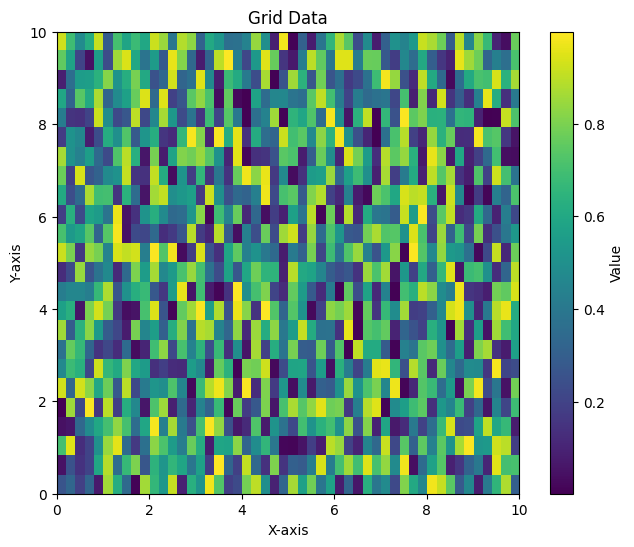

In [ ]:
'''
print(original_data)
len(original_data)
import numpy as np
import matplotlib.pyplot as plt

# Example grid data
original_data = np.random.rand(24, 50)  # Example 10x10 grid data, replace with your actual data

# Plot grid data
plt.figure(figsize=(8, 6))
plt.imshow(original_data, cmap='viridis', extent=[0, 10, 0, 10])
plt.colorbar(label='Value')
plt.title('Grid Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
'''

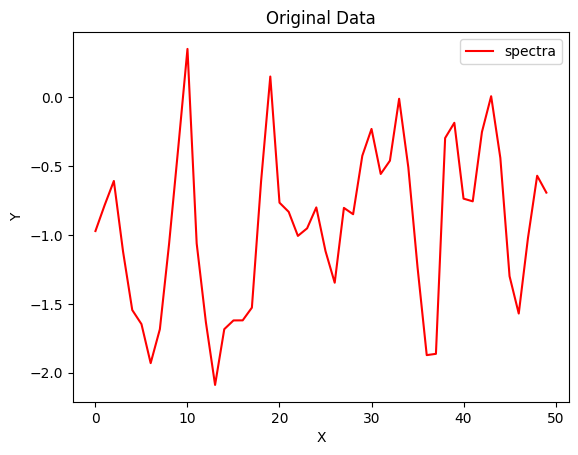

In [ ]:
# Add Gaussian noise
mean = 0
std_deviation = 25
#adding seed
rnd_seed = 42
rng = np.random.default_rng(seed=rnd_seed)
#change 0.0001 to 0.0001
gaussian_noise = 0.01 * rng.normal(mean, std_deviation, original_data.shape)
#gaussian_noisy_data = original_data + np.random.normal(mean, std_deviation, original_data.shape)
# Add Poisson noise
lambda_value = 10
#change 0.001 to 0.0001
poisson_noise =  0.01 * (rng.poisson(lambda_value, original_data.shape) - lambda_value)
#poisson_noisy_data = np.random.poisson(lambda_value, original_data.shape)

plt.plot(np.arange(0,len(data.columns)), data.iloc[4].T, color='red', label='spectra')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.legend()
plt.show()

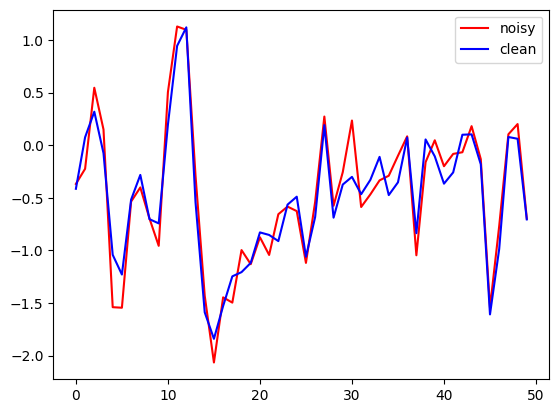

In [ ]:
# combining two noise
noisy_data = original_data + gaussian_noise + poisson_noise
# save the noisy data to a new .npz file
lables = data
plt.plot(np.arange(0,len(data.columns)), noisy_data.iloc[0].T, color='red', label='noisy')
plt.plot(np.arange(0,len(data.columns)), lables.iloc[0].T, color='blue', label='clean')
plt.legend()



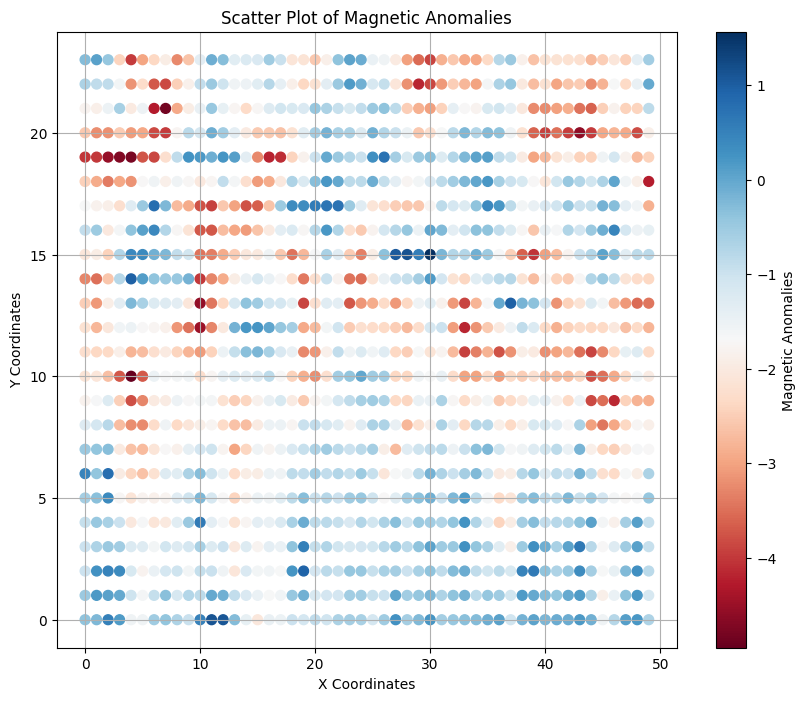

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(noisy_data)
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
#x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
#y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Magnetic Anomalies')
plt.grid(True)
plt.show()

In [ ]:
print(noisy_data)
len(noisy_data)

          0         1         2         3         4         5         6   \
0  -0.368621 -0.224924  0.545613  0.149121 -1.540259 -1.545345 -0.536468   
1  -0.479120  0.173118  0.080911 -0.011478 -1.004993 -1.638620 -0.918500   
2  -0.992541  0.290327  0.483334  0.387279 -1.165704 -1.809359 -1.468506   
3  -0.979709 -0.693253 -0.476971 -0.565627 -1.222096 -1.275518 -1.602931   
4  -0.907706 -0.462330 -0.626354 -1.000015 -2.047543 -1.649180 -2.120808   
5  -0.585122 -0.329261  0.394924 -1.731214 -2.112153 -1.817165 -1.861058   
6   0.477818 -0.398565  0.790457 -1.970131 -2.391998 -2.649225 -2.193114   
7  -0.494926 -0.410929 -0.297861 -1.988059 -2.635382 -2.722280 -2.110650   
8  -1.274913 -1.120856 -0.779618 -2.693435 -3.198041 -3.221460 -2.278386   
9  -1.825789 -1.650331 -1.236622 -2.479255 -3.786821 -3.275452 -1.983440   
10 -2.125035 -2.091204 -2.673870 -3.717626 -4.951132 -3.701874 -1.510896   
11 -2.255740 -2.358867 -2.350395 -1.886732 -2.795773 -2.687271 -2.247882   
12 -2.189147

24

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2 / (1-0.2), random_state=42)

index_train, index_test, _, _ = train_test_split(np.arange(len(noisy_data)), np.arange(len(noisy_data)), test_size=0.2, random_state=42)
index_train, index_val, _, _ = train_test_split(index_train, index_train, test_size=0.2 / (1-0.2), random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

spilitin data

In [ ]:
print("Original set - Input shape:", noisy_data.shape, "Output shape:", lables.shape)
print("Training set - Input shape:", X_train.shape, "Output shape:", y_train.shape)
print("Validation set - Input shape:", X_val.shape, "Output shape:", y_val.shape)
print("Testing set - Input shape:", X_test.shape, "Output shape:", y_test.shape)

Original set - Input shape: (24, 50) Output shape: (24, 50)
Training set - Input shape: (14, 50) Output shape: (14, 50)
Validation set - Input shape: (5, 50) Output shape: (5, 50)
Testing set - Input shape: (5, 50) Output shape: (5, 50)


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 3.7411 - val_loss: 2.3040
Epoch 2/50
1/1 [==============================] - 0s 42ms/step - loss: 2.9670 - val_loss: 1.8129
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 2.3298 - val_loss: 1.4346
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 1.8223 - val_loss: 1.1663
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 1.4384 - val_loss: 1.0012
Epoch 6/50
1/1 [==============================] - 0s 28ms/step - loss: 1.1696 - val_loss: 0.9257
Epoch 7/50
1/1 [==============================] - 0s 28ms/step - loss: 1.0011 - val_loss: 0.9200
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 0.9123 - val_loss: 0.9589
Epoch 9/50
1/1 [==============================] - 0s 35ms/step - loss: 0.8773 - val_loss: 1.0152
Epoch 10/50
1/1 [==============================] - 0s 29ms/step - loss: 0.8683 - val_loss: 1.0661
Epoch 11/50
1/1 [==============

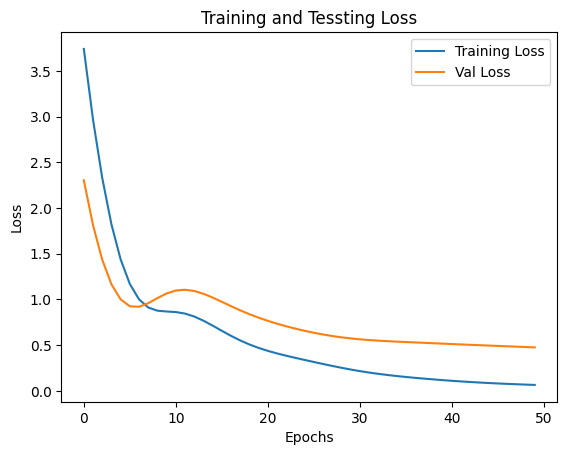

In [ ]:
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(50, 1)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dense(50))  # Output layer with 1 neuron for regression

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
denoised_data = model.predict(X_test)

print(denoised_data)
len(denoised_data)

model.save_weights("model.h5")
model.summary()



# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Tessting Loss')
plt.legend()
plt.show()



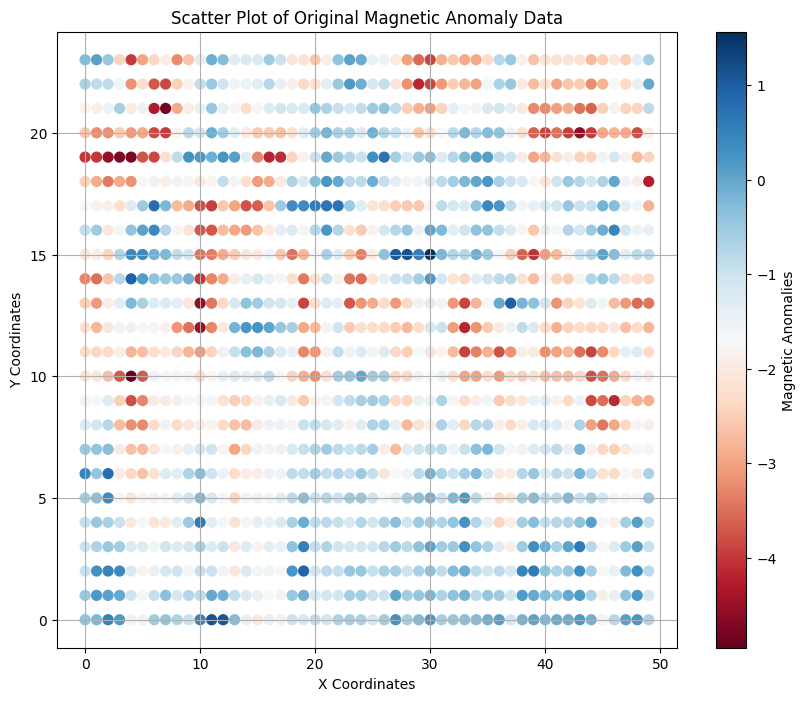

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(noisy_data)
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
extent = [581717.33, 581840.03 , 4277366.1, 4277481.2]
x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
#x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))
rows = [581717.33, 581840.03]
columns = [4277366.1, 4277481.2]
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))
# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Original Magnetic Anomaly Data')
plt.grid(True)
plt.show()

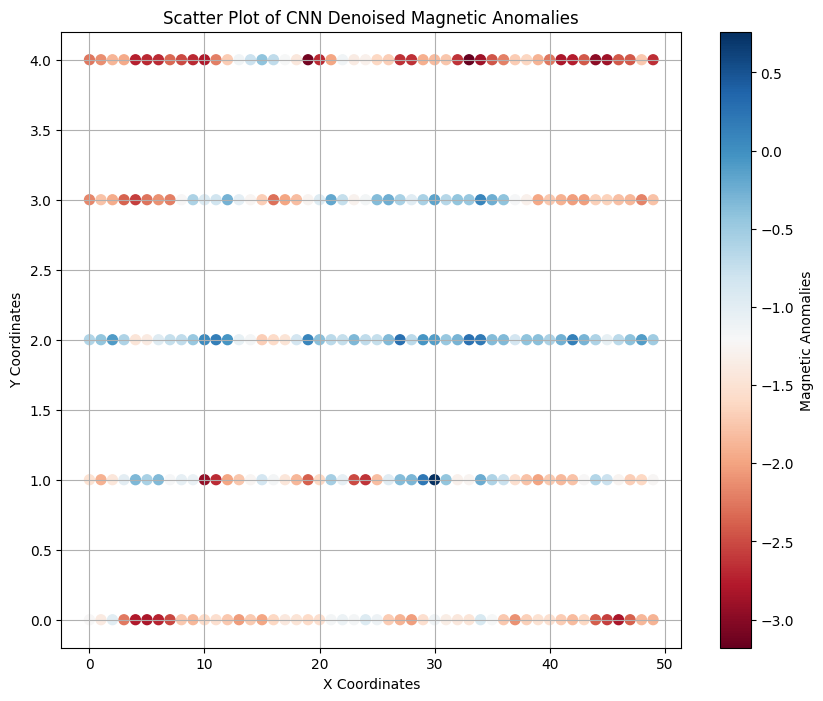

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(denoised_data)
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
#x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
#y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of CNN Denoised Magnetic Anomalies')
plt.grid(True)
plt.show()

IndexError: index 8 is out of bounds for axis 0 with size 5

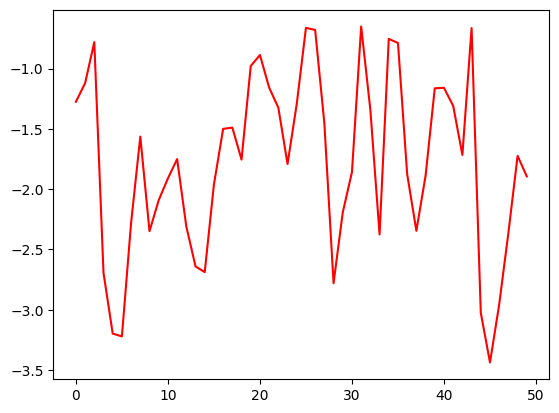

In [ ]:
plt.plot(np.arange(0,len(data.columns)), noisy_data.iloc[index_test[0]].T, color='red', label='noisy')
plt.plot(np.arange(0,len(data.columns)), denoised_data[index_test[0]].T, color='blue', label='denoised')
plt.xlabel('Wavelengths')
plt.ylabel('Spectral Values')
plt.title('Noisy and Denoised Data')
plt.legend()
plt.show()

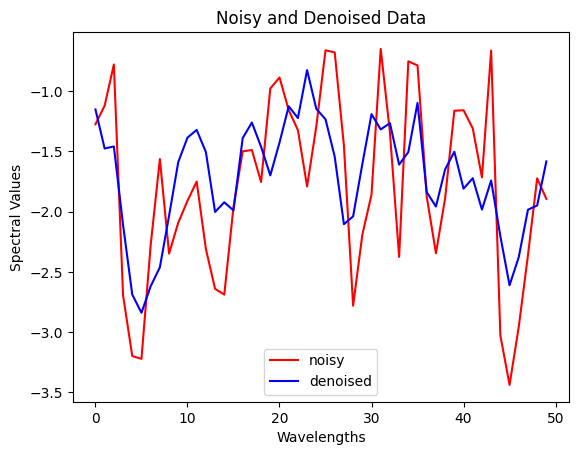

In [ ]:
plt.plot(np.arange(0,len(data.columns)), noisy_data.iloc[index_test[0]].T, color='red', label='noisy')
plt.plot(np.arange(0,len(data.columns)), denoised_data[0].T, color='blue', label='denoised')
plt.xlabel('Wavelengths')
plt.ylabel('Spectral Values')
plt.title('Noisy and Denoised Data')
plt.legend()
plt.show()

In [ ]:
denoised_data = model.predict(noisy_data)

1/1 [==============================] - 0s 48ms/step


In [ ]:
import numpy
from PIL import Image


def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = numpy.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final



removed_noise = median_filter(np.array(data), 2)
removed_noise

array([[ 0.        ,  0.        ,  0.075072  , ...,  0.        ,
         0.06077143,  0.        ],
       [-0.65140003,  0.005296  ,  0.31799999, ..., -0.09125713,
         0.06440429,  0.        ],
       [-0.88065004, -0.06448   ,  0.43520001, ..., -0.26002857,
         0.06440429,  0.        ],
       ...,
       [-1.17925   , -1.83500004, -1.83500004, ..., -2.61199999,
        -2.64899993,  0.        ],
       [-0.3495    , -1.0151    , -1.0151    , ..., -2.204     ,
        -2.21600008,  0.        ],
       [-0.3039    , -0.3039    , -0.49419999, ..., -1.76999998,
        -1.74800003,  0.        ]])

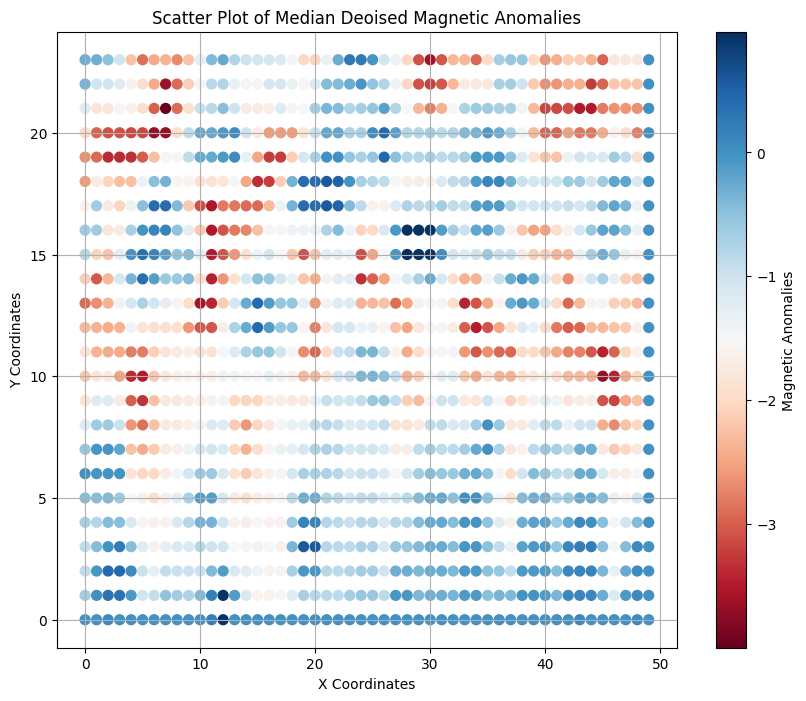

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(removed_noise )
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
#x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
#y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Median Deoised Magnetic Anomalies')
plt.grid(True)
plt.show()

In [ ]:
import scipy.ndimage as ndimage

In [ ]:
img = ndimage.gaussian_filter(np.array(data), sigma=(0.4), order=0)

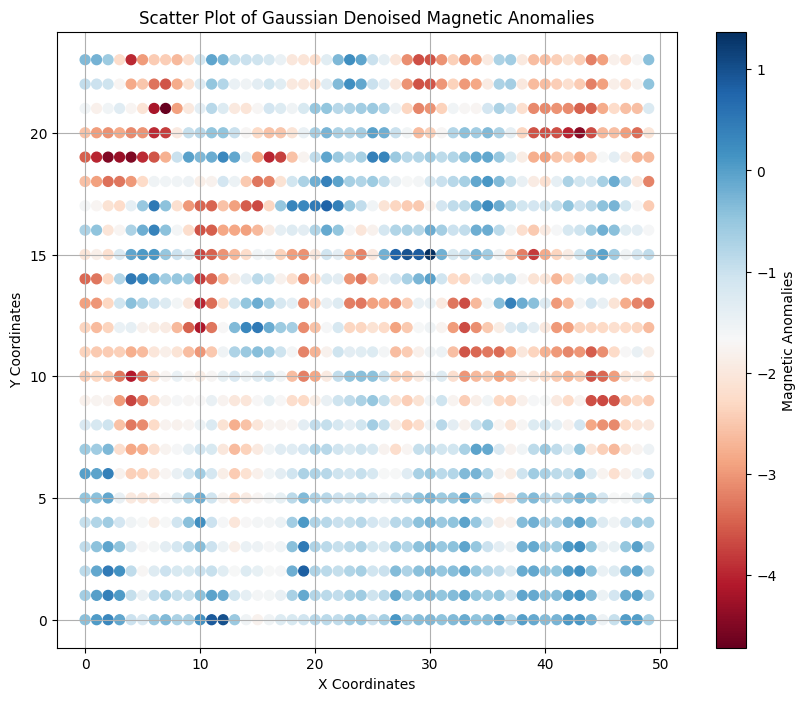

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(img)
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
#x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
#y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Gaussian Denoised Magnetic Anomalies')
plt.grid(True)
plt.show()

In [ ]:
from  skimage.restoration._denoise import denoise_wavelet

In [ ]:
denoised_img = denoise_wavelet(np.array(data), sigma=0.5, rescale_sigma=True)

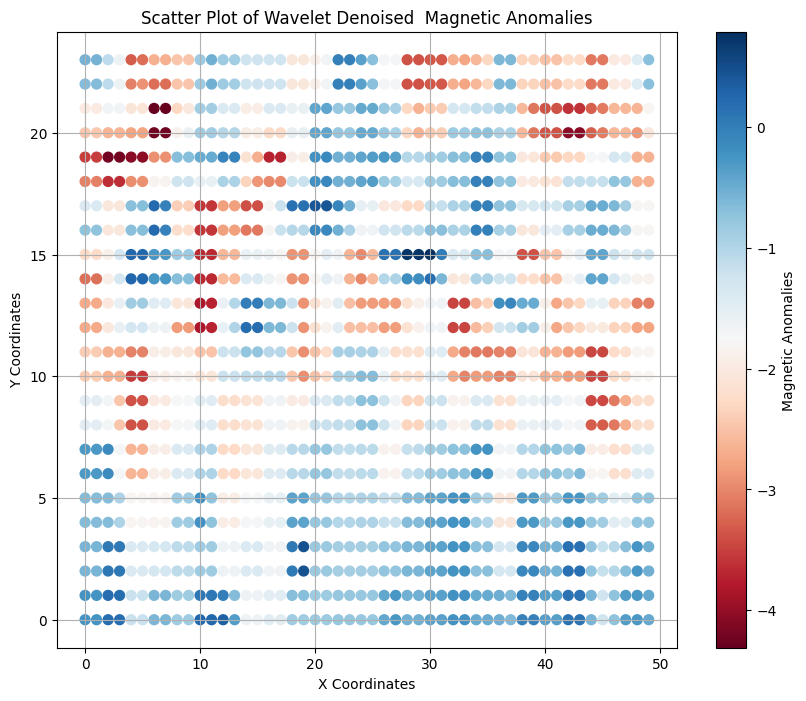

In [ ]:
# Convert grid data to DataFrame
df = pd.DataFrame(denoised_img)
import matplotlib.pyplot as plt

# Assuming the provided data is in a DataFrame named df
# Extracting magnetic anomalies from the DataFrame
magnetic_anomalies = df.values

# Generating x and y coordinates based on the shape of the magnetic anomalies array
num_rows, num_cols = magnetic_anomalies.shape
#x_coordinates = [581717.33, 581840.03 ]  # Replace [...] with your x coordinates
#y_coordinates = [4277366.1, 4277481.2]  # Replace [...] with your y coordinates
x_coordinates, y_coordinates = np.meshgrid(range(num_cols), range(num_rows))

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coordinates, y_coordinates, c=magnetic_anomalies, cmap='RdBu', s=50, marker='o')
plt.colorbar(label='Magnetic Anomalies')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Wavelet Denoised  Magnetic Anomalies')
plt.grid(True)
plt.show()

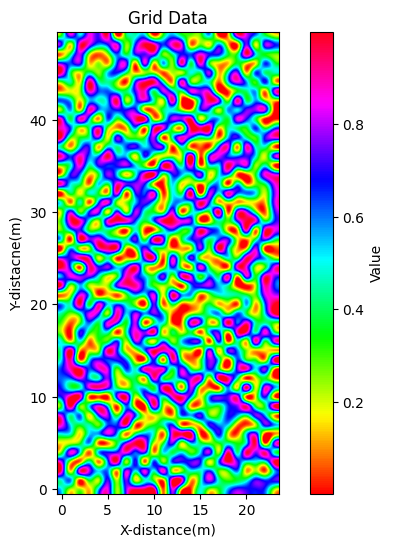

In [ ]:
# Example grid data
denoised_data = np.random.rand(24, 50)  # Example 10x10 grid data, replace with your actual data

# Plot grid data
plt.figure(figsize=(8, 6))
plt.imshow(denoised_data.T, cmap='hsv', origin='lower', interpolation="spline36")
plt.colorbar(label='Value')
plt.title('Grid Data')
plt.xlabel('X-distance(m)')
plt.ylabel('Y-distacne(m)')
plt.show()

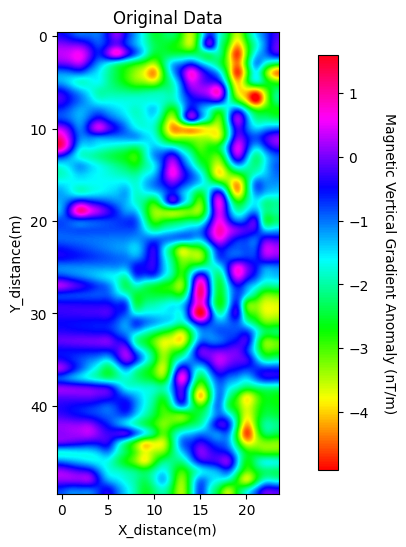

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your 2D array of image data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the image
a = ax.imshow(data.T, cmap="hsv", interpolation="spline36")
ax.set_title("Original Data")

# Add color bar
cbar = fig.colorbar(a, ax=ax, shrink=0.9)  # Specify the axis for the color bar

# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly (nT/m)', rotation=270, labelpad=20)  # Adjust label properties as needed

plt.xlabel('X_distance(m)')
plt.ylabel('Y_distance(m)')

plt.show()

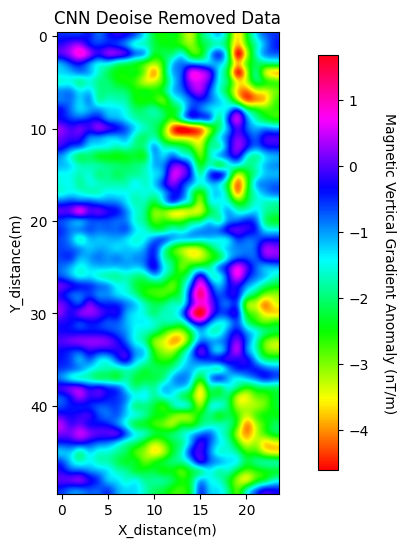

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your 2D array of image data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the image
a = ax.imshow(denoised_data.T, cmap="hsv", interpolation="spline36")
ax.set_title("CNN Deoise Removed Data")

# Add color bar
cbar = fig.colorbar(a, ax=ax, shrink=0.9)  # Specify the axis for the color bar

# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly (nT/m)', rotation=270, labelpad=20)  # Adjust label properties as needed

plt.xlabel('X_distance(m)')
plt.ylabel('Y_distance(m)')

plt.show()

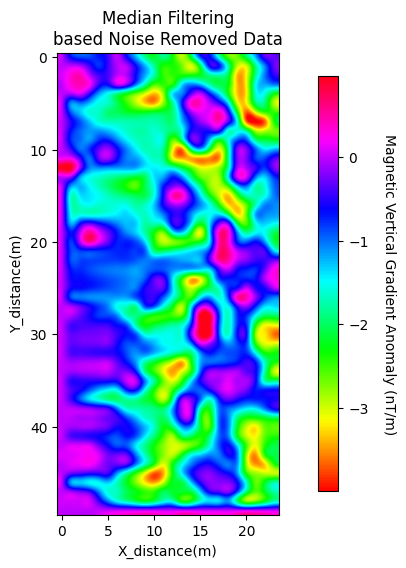

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your 2D array of image data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the image
a = ax.imshow(removed_noise.T, cmap="hsv", interpolation="spline36")
ax.set_title("Median Filtering\nbased Noise Removed Data")

# Add color bar
cbar = fig.colorbar(a, ax=ax, shrink=0.9)  # Specify the axis for the color bar
# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly (nT/m)', rotation=270, labelpad=20)  # Adjust label properties as needed

plt.xlabel('X_distance(m)')
plt.ylabel('Y_distance(m)')


plt.show()

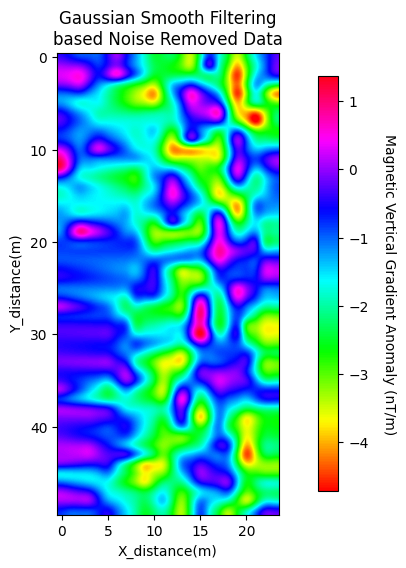

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your 2D array of image data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the image
a = ax.imshow(img.T, cmap="hsv", interpolation="spline36")
ax.set_title("Gaussian Smooth Filtering\nbased Noise Removed Data")

# Add color bar
cbar = fig.colorbar(a, ax=ax, shrink=0.9)  # Specify the axis for the color bar
# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly (nT/m)', rotation=270, labelpad=20)  # Adjust label properties as needed

plt.xlabel('X_distance(m)')
plt.ylabel('Y_distance(m)')


plt.show()

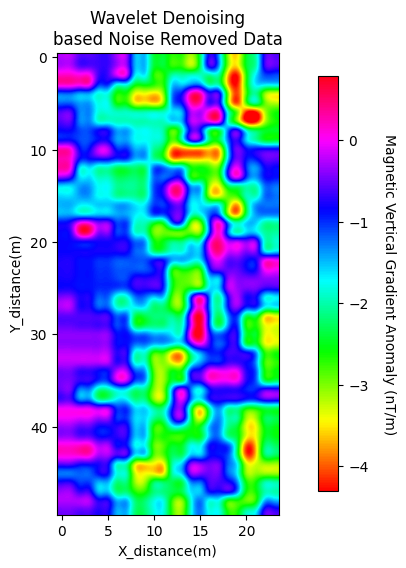

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your 2D array of image data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the image
a = ax.imshow(denoised_img.T, cmap="hsv", interpolation="spline36")
ax.set_title("Wavelet Denoising\nbased Noise Removed Data")

# Add color bar
cbar = fig.colorbar(a, ax=ax, shrink=0.9)  # Specify the axis for the color bar
# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly (nT/m)', rotation=270, labelpad=20)  # Adjust label properties as needed

plt.xlabel('X_distance(m)')
plt.ylabel('Y_distance(m)')

plt.show()

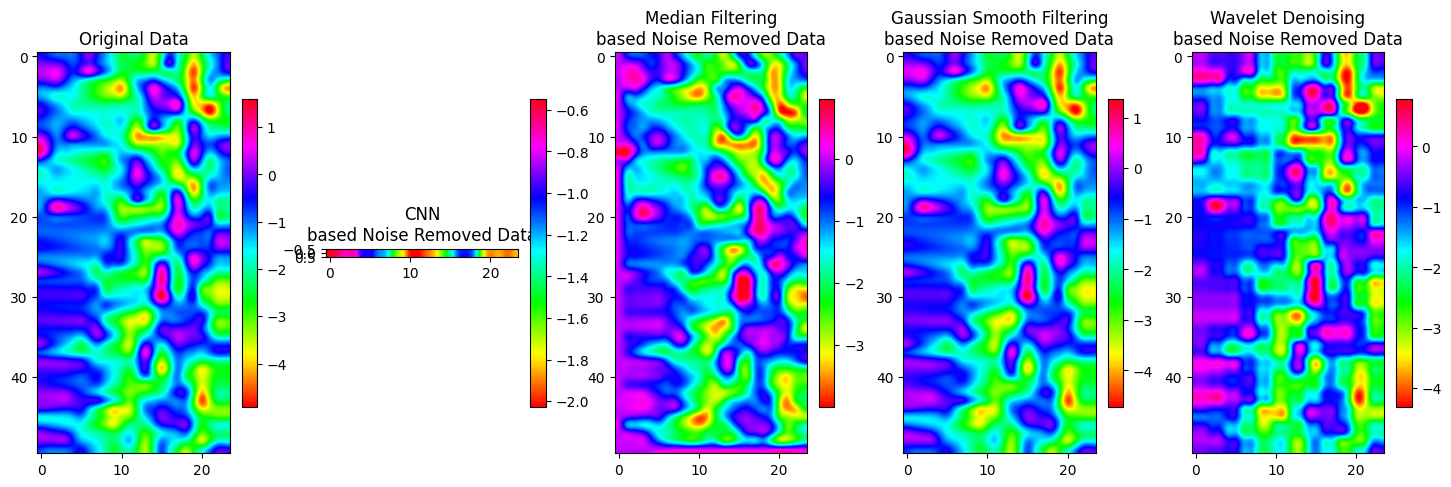

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(18,20))
a = ax[0].imshow(data.T,cmap="hsv",interpolation="spline36")
ax[0].set_title("Original Data")
fig.colorbar(a, shrink=0.2)

b = ax[1].imshow(denoised_data.T,cmap="hsv",interpolation="spline36")
ax[1].set_title("CNN\based Noise Removed Data")
fig.colorbar(b, shrink=0.2)

c = ax[2].imshow(removed_noise.T,cmap="hsv",interpolation="spline36")
ax[2].set_title("Median Filtering\nbased Noise Removed Data")
fig.colorbar(c, shrink=0.2)


d = ax[3].imshow(img.T,cmap="hsv",interpolation="spline36")
ax[3].set_title("Gaussian Smooth Filtering\nbased Noise Removed Data")
fig.colorbar(d, shrink=0.2)

e = ax[4].imshow(denoised_img.T,cmap="hsv",interpolation="spline36")
ax[4].set_title("Wavelet Denoising\nbased Noise Removed Data")
fig.colorbar(e, shrink=0.2)
# Add label to color bar
cbar.set_label('Magnetic Vertical Gradient Anomaly', rotation=270, labelpad=20)  # Adjust label properties as needed


